In [2]:
import rasterio as rio 
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm_notebook

In [3]:
# Reference
df = xr.open_dataset("/Users/pdas47/phd/Mekong_v5.0.1/MetSim/MekongDS/dom.nc")
df

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/pdas47/phd/Mekong_v5.0.1/MetSim/MekongDS/dom.nc'

In [8]:
# Making domain file
mask = rio.open("../backend/data/ancillary/MASK.tif")
mask_ar = mask.read(1, masked=True)#.astype(float)#.filled(np.nan)

elev = rio.open("../backend/data/ancillary/SRTM.tif")
elev_ar = elev.read(1, masked=True)#.astype(float)#.filled(np.nan)

# elev_ar.shape
x_res, y_res = mask.res
lon_0, lat_0 = mask.xy(0, 0)
lons1d = (np.arange(0, mask.shape[1])*x_res + lon_0).round(5)
lats1d = (np.arange(0, mask.shape[0])*-y_res + lat_0).round(5)

domain_ds = xr.Dataset(
    data_vars={
        "mask": (["lat", "lon"], mask_ar),
        "elev": (["lat", "lon"], elev_ar)
    },
    coords={
        "lat": (["lat"], lats1d),
        "lon": (["lon"], lons1d)
    }
)

# domain_ds.to_netcdf("../backend/params/metsim/domain.nc")

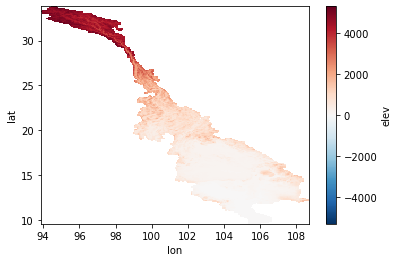

In [9]:
domain_ds['elev'].plot()

In [123]:
#### OLD - Created while learning to use Metsim

# Making forcing files
dates = pd.date_range("2001-01-01", "2001-12-30")

precips = np.zeros((len(dates), len(lats1d), len(lons1d)))
tmaxes = np.zeros((len(dates), len(lats1d), len(lons1d)))
tmins = np.zeros((len(dates), len(lats1d), len(lons1d)))
winds = np.zeros((len(dates), len(lats1d), len(lons1d)))

for i, d in enumerate(dates):
    precip = rio.open(f"../backend/data/processed/precipitation/{d.strftime('%Y-%m-%d')}_IMERG.asc")
    precip_ar = precip.read(1, masked=True).astype(np.float32).filled(np.nan)
    precips[i, :, :] = precip_ar
    #     print(precip_ar.shape)
    
    tmax = rio.open(f"../backend/data/processed/tmax/{d.strftime('%Y-%m-%d')}_TMAX.asc")
    tmax_ar = tmax.read(1, masked=True).astype(np.float32).filled(np.nan)
    tmaxes[i, :, :] = tmax_ar
    
    tmin = rio.open(f"../backend/data/processed/tmin/{d.strftime('%Y-%m-%d')}_TMIN.asc")
    tmin_ar = tmin.read(1, masked=True).astype(np.float32).filled(np.nan)
    tmins[i, :, :] = tmin_ar
    
    uwnd = rio.open(f"../backend/data/processed/uwnd/{d.strftime('%Y-%m-%d')}_UWND.asc")
    uwnd_ar = uwnd.read(1, masked=True).astype(np.float32).filled(np.nan)
    
    vwnd = rio.open(f"../backend/data/processed/vwnd/{d.strftime('%Y-%m-%d')}_VWND.asc")
    vwnd_ar = vwnd.read(1, masked=True).astype(np.float32).filled(np.nan)

    winds[i, :, :] = 0.75 * np.sqrt(vwnd_ar**2 + uwnd_ar**2)
    
    
# Add Temperature, Wind
forcings_ds = xr.Dataset(
    data_vars={
        "precip": (["time", "lat", "lon"], precips),
        "tmax": (["time", "lat", "lon"], tmaxes),
        "tmin": (["time", "lat", "lon"], tmins),
        "wind": (["time", "lat", "lon"], winds)
    },
    coords={
        "time": (["time"], dates),
        "lat": (["lat"], lats1d),
        "lon": (["lon"], lons1d)
    }
)

In [124]:
forcings_ds

<xarray.Dataset>
Dimensions:  (lat: 389, lon: 239, time: 364)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-30
  * lat      (lat) float64 33.78 33.72 33.66 33.59 ... 9.719 9.656 9.594 9.531
  * lon      (lon) float64 93.84 93.91 93.97 94.03 ... 108.5 108.6 108.7 108.7
Data variables:
    precip   (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tmax     (time, lat, lon) float64 -2.105 -2.105 -2.105 ... nan nan nan
    tmin     (time, lat, lon) float64 -13.61 -13.61 -13.61 ... nan nan nan
    wind     (time, lat, lon) float64 4.076 4.076 4.076 ... 6.033 6.033 6.033

In [130]:
forcings_ds.sel(time=slice('2001-01-01', '2001-03-31')).to_netcdf("../backend/params/metsim/state.nc")
forcings_ds.sel(time=slice('2001-04-01', '2001-12-30')).to_netcdf("../backend/params/metsim/forcings_2001.nc")

90

In [19]:
d = xr.open_dataset("../backend/data/metsim_inputs/2001.nc")
d

<xarray.Dataset>
Dimensions:  (lat: 388, lon: 237, time: 365)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * lat      (lat) float64 33.78 33.72 33.66 33.59 ... 9.781 9.719 9.656 9.594
  * lon      (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.5 108.6 108.7
Data variables:
    precip   (time, lat, lon) float64 ...
    tmax     (time, lat, lon) float64 ...
    tmin     (time, lat, lon) float64 ...
    wind     (time, lat, lon) float64 ...
    extent   (lat, lon) float32 ...

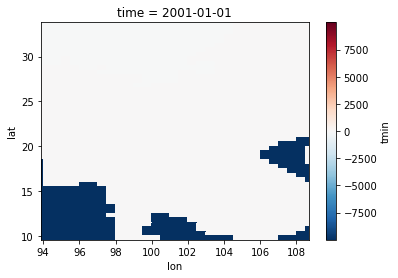

In [26]:
d.tmin.isel(time=0).plot()